In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

In [4]:
root_dir = 'D:\DBDA Project\American Sign\American Sign Language Digits Dataset'

image_data = []

for label in range(10):
    label_dir = os.path.join(root_dir, str(label), 'Input Images - Sign {}'.format(label))
    for image_file in os.listdir(label_dir):
        image = Image.open(os.path.join(label_dir, image_file))
        image_data.append({
            'label': label,
            'color_image': image
        })

df = pd.DataFrame(image_data)

In [5]:
df

,label,color_image
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...
4995,9,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4996,9,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4997,9,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4998,9,<PIL.JpegImagePlugin.JpegImageFile image mode=...


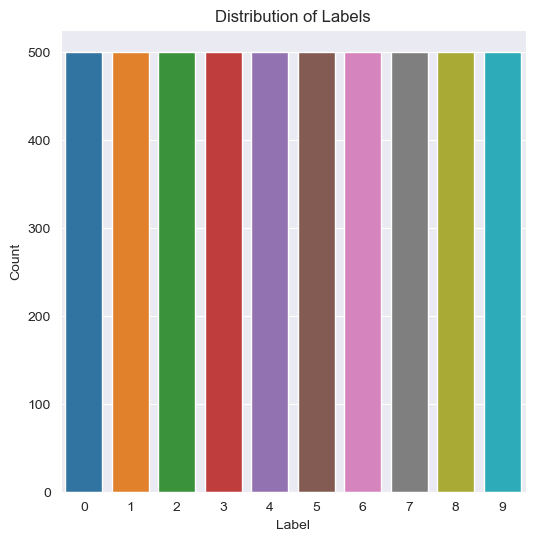

In [6]:
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=df,x='label')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

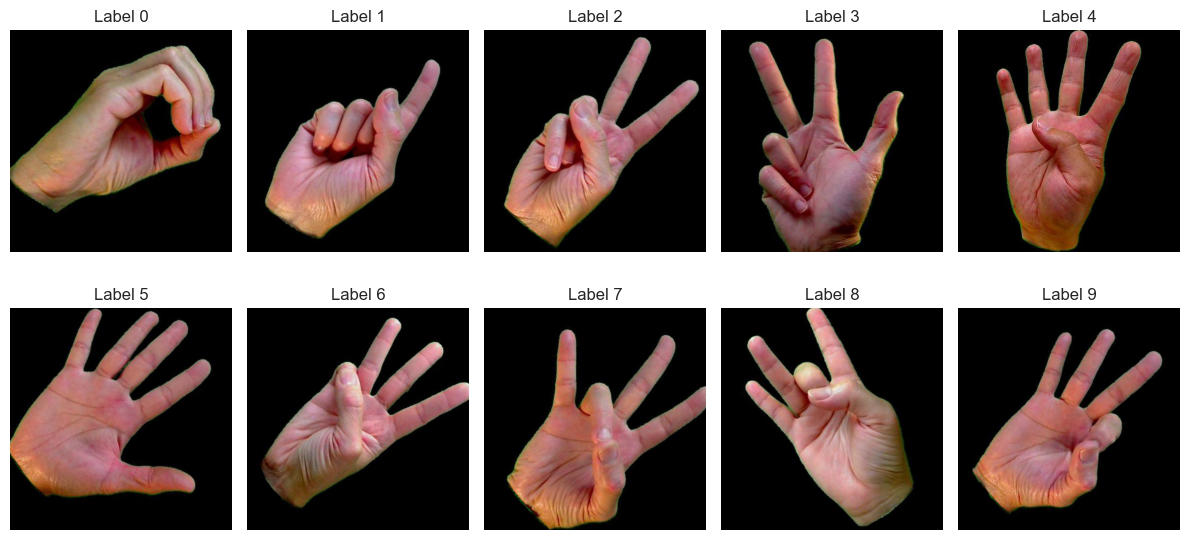

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, (label, image) in enumerate(df.groupby('label').first().reset_index()[['label', 'color_image']].itertuples(index=False)):
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title('Label {}'.format(label))
    ax.axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Preprocessing steps
images = np.array(df['color_image'].tolist())
labels = np.array(df['label'])

In [9]:
# Resize images to desired dimensions
resized_images = []
for image in images:
    resized_image = image.resize((32, 32))  # Resize the image to the desired size
    resized_images.append(np.array(resized_image))
images = np.array(resized_images)

In [10]:
# Normalize pixel values
images = images / 255.0

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [12]:
# Convert labels to categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=10, activation='softmax'))

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 75)        2100      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 16, 16, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 50)        2

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [15]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.0001)
history = model.fit(datagen.flow(X_train, y_train), epochs=10, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/10
125/125 [==============================] - 28s 200ms/step - loss: 1.5726 - accuracy: 0.4667 - val_loss: 2.3892 - val_accuracy: 0.1110 - lr: 0.0100
Epoch 2/10
125/125 [==============================] - 25s 196ms/step - loss: 0.7317 - accuracy: 0.7602 - val_loss: 2.4657 - val_accuracy: 0.1170 - lr: 0.0100
Epoch 3/10
125/125 [==============================] - 25s 198ms/step - loss: 0.4880 - accuracy: 0.8410 - val_loss: 1.6728 - val_accuracy: 0.4100 - lr: 0.0100
Epoch 4/10
125/125 [==============================] - 25s 201ms/step - loss: 0.3400 - accuracy: 0.8842 - val_loss: 0.5792 - val_accuracy: 0.8640 - lr: 0.0100
Epoch 5/10
125/125 [==============================] - 25s 201ms/step - loss: 0.2607 - accuracy: 0.9125 - val_loss: 0.2094 - val_accuracy: 0.9480 - lr: 0.0100
Epoch 6/10
125/125 [==============================] - 25s 199ms/step - loss: 0.2010 - accuracy: 0.9388 - val_loss: 0.0988 - val_accuracy: 0.9790 - lr: 0.0100
Epoch 7/10
125/125 [==============================] 

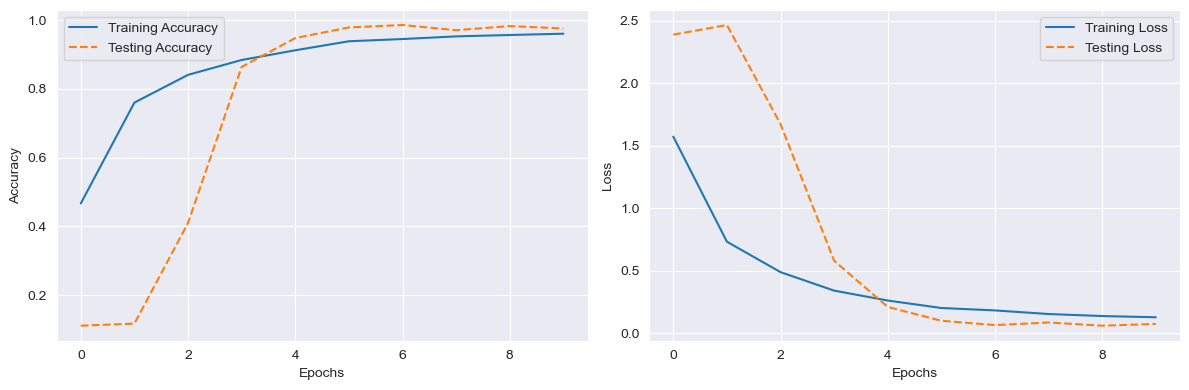

In [16]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Define plot labels and styles
plot_labels = ['Accuracy', 'Loss']
plot_styles = ['-', '--']

# Plot training and testing accuracy/loss
for i, metric in enumerate(['accuracy', 'loss']):
    train_metric = history.history[metric]
    test_metric = history.history['val_' + metric]
    axs[i].plot(train_metric, label='Training ' + metric.capitalize(), linestyle=plot_styles[0])
    axs[i].plot(test_metric, label='Testing ' + metric.capitalize(), linestyle=plot_styles[1])
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel(plot_labels[i])
    axs[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [17]:
# Get the model's predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

32/32 [==============================] - 3s 41ms/step


In [18]:
# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

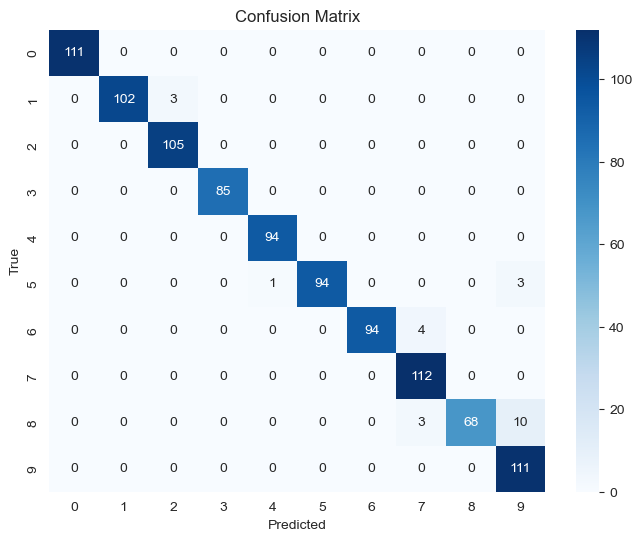

In [19]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
accuracy = model.evaluate(X_test, y_test)
print(f'validation test results - Loss: {accuracy[0]} - Accuracy: {accuracy[1]*100}%')

32/32 [==============================] - 1s 42ms/step - loss: 0.0733 - accuracy: 0.9760
validation test results - Loss: 0.07332661747932434 - Accuracy: 97.60000109672546%


In [22]:
import pickle

# Load the saved model from the pickle file
with open('model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [26]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Load and preprocess the image
image_path = '4.jpg'  # Replace with your image file path
target_size = (32, 32)  # Adjust based on your model's input size

# Load the image and resize
image = Image.open(image_path)
image = image.resize(target_size)

# Convert the image to a numpy array and preprocess it
image_array = np.array(image)
preprocessed_image = image_array / 255.0  # Normalize pixel values

# # If your model requires input in a specific format (e.g., batch dimension), add that here
input_image = np.expand_dims(preprocessed_image, axis=0)  # Adding a batch dimension

# Make predictions using the loaded model
predictions = loaded_model.predict(input_image)

# Get the predicted class (digit)
predicted_class = np.argmax(predictions)

# Print the predicted class
print("Predicted digit:", predicted_class)
